# 目次

- 評価比較
- 学習状況の確認
- 交差検証
- パラメータ・チューニング
- 再評価
- アンサンブル

# ライブラリ

In [25]:
# データ処理
import csv
import numpy as np
import pandas as pd
import scipy.stats as stats
pd.options.display.float_format = '{:.0f}'.format

# 描画
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
import japanize_matplotlib
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style(style='dark')
from tqdm import tqdm # プログレスバー
mplstyle.use('fast')

# 表示調整
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
# 日本語対応
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP']
plt.rcParams["figure.figsize"] = [20,5] # 表示サイズ
plt.rcParams["font.size"] = 10 # 文字サイズ
# HTML対応
from IPython.core.display import display, HTML
# 全表示対応
display(HTML("<style>.cm-s-ipython span.cm-comment { color: blue; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [26]:
boston_before = pd.read_csv('./boston.csv')
boston_df = pd.read_csv('./boston_processed.csv')

In [27]:
boston_before.shape
boston_before.head()

boston_df.shape
boston_df.head()

(506, 14)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0,18,2,0,1,7,65,4,1,296,15,397,5,24
1,0,0,7,0,0,6,79,5,2,242,18,397,9,22
2,0,0,7,0,0,7,61,5,2,242,18,393,4,35
3,0,0,2,0,0,7,46,6,3,222,19,395,3,33
4,0,0,2,0,0,7,54,6,3,222,19,397,5,36


(493, 14)

,ZN,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,クラスタ1との距離,クラスタ2との距離
0,18,0,-0,7,65,4,1,296,15,397,5,24,280,601
1,0,0,-1,6,79,5,2,242,18,397,9,22,318,667
2,0,0,-1,7,61,5,2,242,18,393,4,35,332,647
3,0,0,-1,7,46,6,3,222,19,395,3,33,372,664
4,0,0,-1,7,54,6,3,222,19,397,5,36,364,664


モデルいろいろ
評価
学習曲線
その他の評価
交差検証
パラメーター・チューニング
アンサンブル
再評価

# 評価比較（複数モデル）

In [56]:
from sklearn.model_selection import train_test_split # データ分割
# アルゴリズム
from sklearn.neighbors import KNeighborsRegressor as KNR # K近傍法（回帰）
from sklearn.linear_model import LinearRegression as LR # 線形回帰
from sklearn.linear_model import Ridge, Lasso, ElasticNet # Ridge回帰、Lasso回帰、ElasticNet回帰
from sklearn.svm import SVR # サポートベクトルマシン
from sklearn.ensemble import RandomForestRegressor as RFR # ランダム・フォレスト（回帰）
from xgboost import XGBRFRegressor as XGBRFR # XGBoost
from sklearn.ensemble import GradientBoostingRegressor as GBR # GBDT（勾配ブースティング木）

# 各評価指標
from sklearn.metrics import r2_score as R2
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

# 評価
def evaluation(model, y_test, y_pred):
    print('='*40)
    print(model.__class__.__name__)
    print('決定係数（R2） = ', R2(y_test, y_pred).round(decimals=3))
    mae = MAE(y_test, y_pred)
    print('平均絶対誤差（MAE） = ', mae.round(decimals=3))
    rmse = np.sqrt(MSE(y_test, y_pred))
    print('平均二乗平方根誤差（RMSE） = ', rmse.round(decimals=3))
    print('RMSE / MAE = ', (rmse / mae).round(decimals=3)) # <, =, > 1.253
    aic = AIC(y_test, y_pred, num_feature=len(boston_df.columns))
    print('AIC = ', aic.round(decimals=3))
    
    return mae, rmse, aic

# AIC（赤池情報量規準）
def AIC(y_test, y_pred, num_feature):
    num_data = len(y_test) # サンプル数
    mse = MSE(y_test, y_pred) # MSE
    rss = (0.5 * np.sum((y_test - y_pred)**2) / num_data) # 残差平方和
    return (num_data * (np.log(2 * np.pi) * (rss / num_data) + 1)) + 2 * (num_feature + 1)


# データ分割
def data_devide(df, test_size=0.2):
    target = 'MEDV'
    X = df.drop(columns=target, axis=1)
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test


# モデリング
def modeling(model, df):
    # ホールドアウト法
    X_train, X_test, y_train, y_test = data_devide(df, test_size=0.2)

    # 学習、予測
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test).round(decimals=2)

    # 評価
    mae, rmse, aic = evaluation(model, y_test, y_pred)

# モデル
rfr_model = RFR(random_state=42) # ランダムフォレスト
lr_model = LR() # 線形回帰
ridge_model = Ridge() # Ridge
lasso_model = Lasso() # Lasso
gbr_model = GBR(random_state=42) # 勾配ブースティング木
xgbrfr_model = XGBRFR(random_state=42) # XGBoost
knr_model = KNR() # K近傍法（回帰）
svr_model = SVR() # サポートベクトルマシン
models = [rfr_model, lr_model, ridge_model, lasso_model, gbr_model, xgbrfr_model, knr_model, svr_model]

$$
    AIC = n(\log(2\pi\frac{S_e}{n}) + 1) + 2(p + 1)
$$
※統計Web参照

n = サンプル数 : len(y_test)  
Se = 残差平方和  
p = 項目数 : num_feature  

$$
    S_e = \frac{1}{2}\sum_{j=0}^{m-1}(y_j - t_j)^2
$$
※統計Web参照

y = y_test  
t = y_pred

## 評価指標

- R2  
　回帰モデルの当てはまりの良さを評価  
　非線形モデルを評価することはできない  
- MAE  
　予測値と実測値の平均的な誤差の大きさを（平等に）評価  
　大きく予測を外したケースを重要視しない  
　誤差を二乗していないため、外れ値の影響を受けにくい  
- MSE  
　大きな誤差を重要視して評価  
- RMSE（ルートMSE）  
　大きな誤差を重要視して評価  
　外れ値が含まれると値が著しく大きくなる  
- AIC  
　モデルの複雑さ適合性能の両方を評価  
　不必要なパラメータが含まれていないモデルが選ぶ基準とすることができる  
　（尤度はパラメータ数を増やすと大きくなりやすいため）  

- RMSE / MAE  
  < 1.253  
  各サンプルに同程度の大きさの誤差が生じている可能性がある。  
  
  = 1.253  
  誤差が正規分布に従う場合、適切なモデル構築ができている可能性が高い。  
  
  .> 1.253    
  予測を大きく外しているデータが存在する可能性がある。  

## 調整前

In [57]:
# 評価
for model in models:
    modeling(model, boston_before)

RandomForestRegressor
決定係数（R2） =  0.892
平均絶対誤差（MAE） =  2.04
平均二乗平方根誤差（RMSE） =  2.811
RMSE / MAE =  1.378
AIC =  139.26
LinearRegression
決定係数（R2） =  0.669
平均絶対誤差（MAE） =  3.189
平均二乗平方根誤差（RMSE） =  4.929
RMSE / MAE =  1.545
AIC =  154.324
Ridge
決定係数（R2） =  0.666
平均絶対誤差（MAE） =  3.133
平均二乗平方根誤差（RMSE） =  4.947
RMSE / MAE =  1.579
AIC =  154.49
Lasso
決定係数（R2） =  0.667
平均絶対誤差（MAE） =  3.253
平均二乗平方根誤差（RMSE） =  4.94
RMSE / MAE =  1.519
AIC =  154.427
GradientBoostingRegressor
決定係数（R2） =  0.915
平均絶対誤差（MAE） =  1.912
平均二乗平方根誤差（RMSE） =  2.492
RMSE / MAE =  1.303
AIC =  137.705
XGBRFRegressor
決定係数（R2） =  0.9
平均絶対誤差（MAE） =  2.088
平均二乗平方根誤差（RMSE） =  2.707
RMSE / MAE =  1.296
AIC =  138.734
KNeighborsRegressor
決定係数（R2） =  0.647
平均絶対誤差（MAE） =  3.664
平均二乗平方根誤差（RMSE） =  5.085
RMSE / MAE =  1.388
AIC =  155.764
SVR
決定係数（R2） =  0.28
平均絶対誤差（MAE） =  4.53
平均二乗平方根誤差（RMSE） =  7.269
RMSE / MAE =  1.604
AIC =  180.554


## 調整後

In [58]:
# 評価
for model in models:
    modeling(model, boston_df)

RandomForestRegressor
決定係数（R2） =  0.929
平均絶対誤差（MAE） =  1.712
平均二乗平方根誤差（RMSE） =  2.292
RMSE / MAE =  1.339
AIC =  133.829
LinearRegression
決定係数（R2） =  0.827
平均絶対誤差（MAE） =  2.799
平均二乗平方根誤差（RMSE） =  3.568
RMSE / MAE =  1.275
AIC =  140.696
Ridge
決定係数（R2） =  0.827
平均絶対誤差（MAE） =  2.798
平均二乗平方根誤差（RMSE） =  3.566
RMSE / MAE =  1.275
AIC =  140.684
Lasso
決定係数（R2） =  0.767
平均絶対誤差（MAE） =  3.125
平均二乗平方根誤差（RMSE） =  4.143
RMSE / MAE =  1.326
AIC =  144.77
GradientBoostingRegressor
決定係数（R2） =  0.908
平均絶対誤差（MAE） =  1.852
平均二乗平方根誤差（RMSE） =  2.599
RMSE / MAE =  1.403
AIC =  135.206
XGBRFRegressor
決定係数（R2） =  0.913
平均絶対誤差（MAE） =  1.863
平均二乗平方根誤差（RMSE） =  2.536
RMSE / MAE =  1.361
AIC =  134.912
KNeighborsRegressor
決定係数（R2） =  0.713
平均絶対誤差（MAE） =  3.401
平均二乗平方根誤差（RMSE） =  4.594
RMSE / MAE =  1.351
AIC =  148.394
SVR
決定係数（R2） =  0.32
平均絶対誤差（MAE） =  4.552
平均二乗平方根誤差（RMSE） =  7.075
RMSE / MAE =  1.554
AIC =  175.0


- R2  
全体的にあてはまりの良さは改善  
  
  
- RMSE / MAE  
Ridge、LinearRegressionが一番大きく外していない。ただしR2が高くない  
RandomForestRegressorは、大きく外している値もある。外れ値をもっと除く。パラメータを変更する。  
SVRは、一番大きく外している。  
  
  
- AIC  
全体的に改善。複数項目を取り除いたのが効いている。  

# 学習状況の確認

## 学習曲線

In [59]:
from sklearn.model_selection import learning_curve # 学習曲線

def plt_learn_curve(model, df):
    # ホールドアウト法
    X_train, X_test, y_train, y_test = data_devide(df, test_size=0.2)

    # データ準備
    train_sizes, train_scores, val_scores = learning_curve(model, X=X_train, y=y_train, train_sizes = np.linspace(0.1, 1.0, 10), cv=5, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)
    
    # 訓練スコア と 検証スコア をプロット
    print(model.__class__.__name__)
    plt.figure(figsize=[10,4])
    plt.title("学習曲線")
    plt.xlabel("訓練サンプル")
    plt.ylabel("スコア")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="訓練スコア")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="検証スコア")

    # 標準偏差の範囲を色付け
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="r", alpha=0.2)
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, color="g", alpha=0.2)

    # Y軸の範囲指定
    plt.ylim(0.5, 1.0)

    # 凡例の表示位置
    plt.grid()
    plt.legend(loc="best")
    plt.show()

## 調整前のデータ

RandomForestRegressor


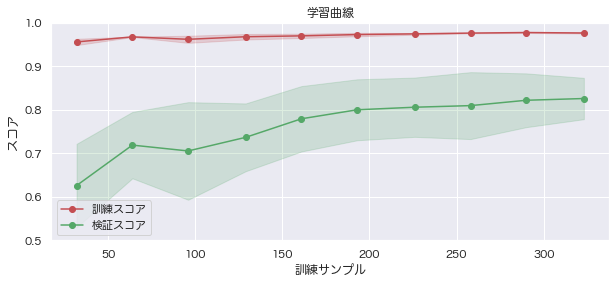

Ridge


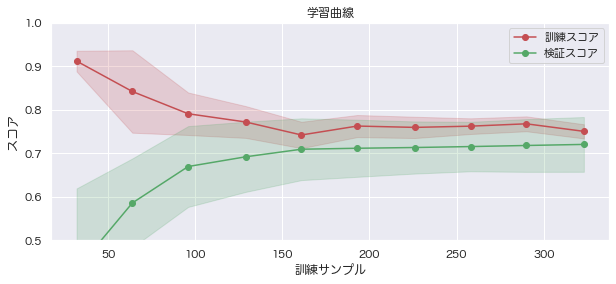

Lasso


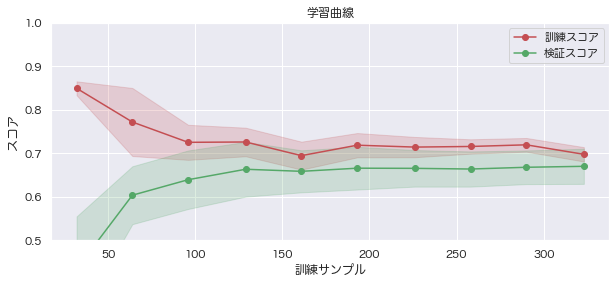

GradientBoostingRegressor


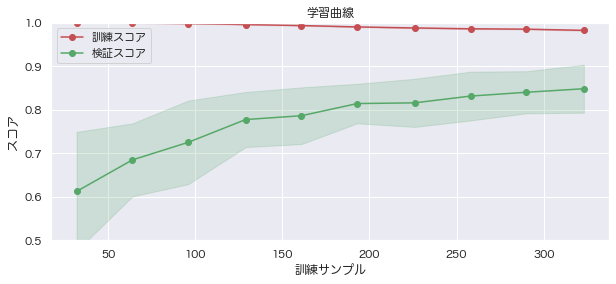

XGBRFRegressor


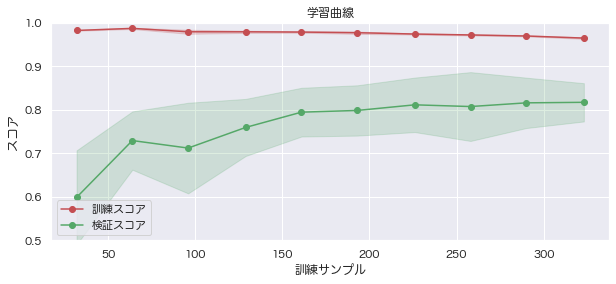

In [32]:
# 実行
models = [rfr_model, ridge_model, lasso_model, gbr_model, xgbrfr_model]
for model in models:
    plt_learn_curve(model, boston_before)

## 調整後のデータ

RandomForestRegressor


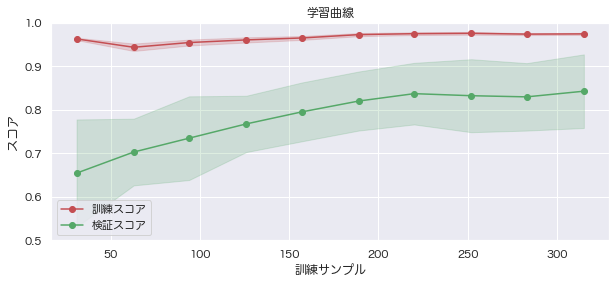

Ridge


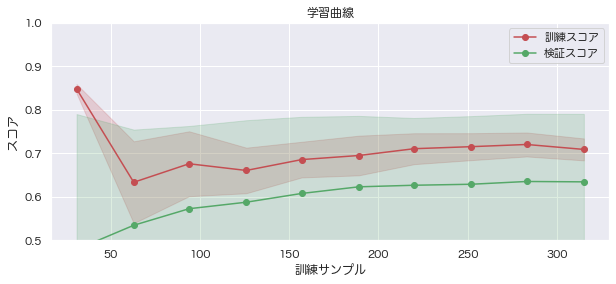

Lasso


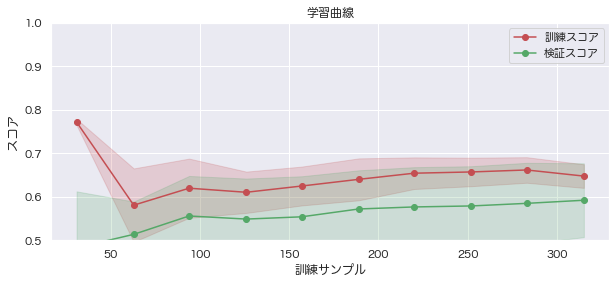

GradientBoostingRegressor


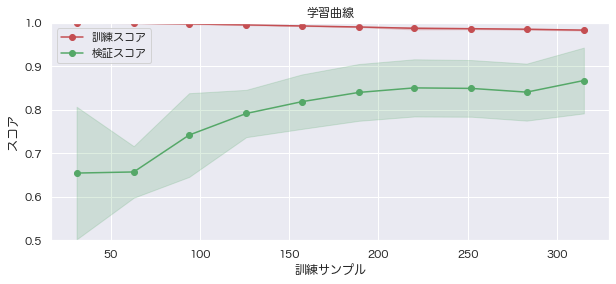

XGBRFRegressor


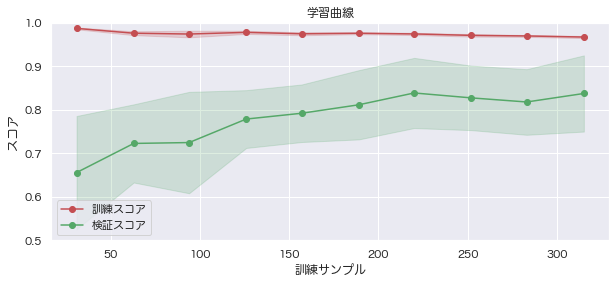

In [33]:
# 実行
for model in models:
    plt_learn_curve(model, boston_df)

- 調整後の結果  
訓練データに適合しているが、検証データに適合しておらず、過学習が起きているものと思われる。  
  
  
- 調整前後の比較・考察  
訓練スコアは、調整前後で大きな違いはない。検証スコアは調整後の方が良いスコアが出ている。  
調整した意味がありそうだが、過学習を抑える対応が必要。  
具体的には、「交差検証」と「パラメーター・チューニング」を行う。  

# 交差検証

## KFold

In [34]:
from sklearn.model_selection import KFold

# Fold数を変化させた評価を比較・考察する。
def fold(model, df, fold):
    # 交差検証
    target = 'MEDV'
    for train_index, val_index in kf.split(df.index):
        X_train = df.drop(columns=target, axis=1).iloc[train_index]
        y_train = df[target].iloc[train_index]
        X_test = df.drop(columns=target, axis=1).iloc[val_index]
        y_test = df[target].iloc[val_index]

        # 学習、予測
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test).round(decimals=2)

        # 評価
        mae, rmse, aic = evaluation(model, y_test, y_pred)
        
        return rmse_mae, aic

In [35]:
# 実行
models = [rfr_model, ridge_model, xgbrfr_model]
kf = KFold(n_splits=11, shuffle=True) # インスタンス
rmse_maes = []
aics = []
for model in models:
    rmse_mae, aic =  fold(model, boston_df, fold=kf)
    rmse_maes.append(rmse_mae)
    aics.append(aic)

print('='*20)
print('(RMSE / MAE)平均 = ', np.mean(rmse_maes).round(decimals=3))
print('AIC平均 = ', np.mean(aics).round(decimals=3))

RandomForestRegressor
決定係数（R2） =  0.905
平均絶対誤差（MAE） =  2.294
平均二乗平方根誤差（RMSE） =  2.977
RMSE / MAE =  1.298
AIC =  83.142
Ridge
決定係数（R2） =  0.669
平均絶対誤差（MAE） =  3.446
平均二乗平方根誤差（RMSE） =  4.547
RMSE / MAE =  1.319
AIC =  93.996
XGBRFRegressor
決定係数（R2） =  0.893
平均絶対誤差（MAE） =  2.205
平均二乗平方根誤差（RMSE） =  2.842
RMSE / MAE =  1.289
AIC =  82.422
(RMSE / MAE)平均 =  1.603
AIC平均 =  86.52


fold=11で、（RMSE / MAE）=1.253に一番近づくため、これらの結果を精度目標とする。    
AICも100以下を目指して、不要なパラメータを除くようにする。  

## StratifiedKFold

In [36]:
from sklearn.model_selection import StratifiedKFold

# 実行
skf = StratifiedKFold(n_splits=11, shuffle=True) # インスタンス
rmse_maes = []
aics = []
for model in models:
    rmse_mae, aic =  fold(model, boston_df, fold=skf)
    rmse_maes.append(rmse_mae)
    aics.append(aic)

print('='*20)
print('(RMSE / MAE)平均 = ', np.mean(rmse_maes).round(decimals=3))
print('AIC平均 = ', np.mean(aics).round(decimals=3))

RandomForestRegressor
決定係数（R2） =  0.91
平均絶対誤差（MAE） =  2.22
平均二乗平方根誤差（RMSE） =  2.991
RMSE / MAE =  1.347
AIC =  83.219
Ridge
決定係数（R2） =  0.709
平均絶対誤差（MAE） =  3.819
平均二乗平方根誤差（RMSE） =  5.764
RMSE / MAE =  1.509
AIC =  105.532
XGBRFRegressor
決定係数（R2） =  0.737
平均絶対誤差（MAE） =  2.63
平均二乗平方根誤差（RMSE） =  4.789
RMSE / MAE =  1.821
AIC =  96.079
(RMSE / MAE)平均 =  1.603
AIC平均 =  94.943


KFoldと大きな変化なし。

# パラメーター・チューニング

In [37]:
# パラメータ・チューニング
from sklearn.model_selection import RandomizedSearchCV

# 探索用関数
def params_search(df, model, params):
    # データ分割
    X_train, X_test, y_train, y_test = data_devide(df, test_size=0.2)

    # パラメータの探索
    random = RandomizedSearchCV(estimator=model, param_distributions=params)
    random_result = random.fit(X_train, y_train)
    print(random_result)
    print(random.best_params_)
    print(random.best_score_)

## ランダム・サーチ

### ランダムフォレスト（回帰）

In [38]:
# ランダムフォレスト（回帰）
params_rfr = {
    'n_estimators' : [i for i in range(10, 100, 10)],
    'max_features' : [i for i in range(1, boston_df.shape[1]-1)],
    'n_jobs' : [i for i in range(1, 10)],
    'min_samples_split' : [i for i in range(10, 100, 10)],
    'max_depth' : [i for i in range(3, 15)]
}
model_rfr = RFR()
params_search(boston_df, model_rfr, params_rfr)

RandomizedSearchCV(estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10,
                                                      11, 12, 13, 14],
                                        'max_features': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12],
                                        'min_samples_split': [10, 20, 30, 40,
                                                              50, 60, 70, 80,
                                                              90],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90],
                                        'n_jobs': [1, 2, 3, 4, 5, 6, 7, 8, 9]})
{'n_jobs': 1, 'n_estimators': 80, 'min_samples_split': 30, 'max_features': 6, 'max_depth': 11}
0.8022603268049495


### Ridge回帰

In [39]:
# Ridge回帰
params_ridge = {
    'alpha' : [i/10 for i  in range(1, 10)],
    'solver' : ['auto','cholesky','sag','saga']
}
model_ridge = Ridge()
params_search(boston_df, model_ridge, params_ridge)

RandomizedSearchCV(estimator=Ridge(),
                   param_distributions={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                                  0.7, 0.8, 0.9],
                                        'solver': ['auto', 'cholesky', 'sag',
                                                   'saga']})
{'solver': 'cholesky', 'alpha': 0.9}
0.6342483722992973


### 勾配ブースティング木

In [40]:
# 勾配ブースティング木
params_gbr = {
    'max_depth' : [i for i in range(5, 15)],
    'subsample' : [i/10 for i  in range(1, 10)],
    'n_estimators' : [i for i in range(900, 1100, 50)],
    'learning_rate' : [i/100 for i  in range(1, 10)]
}
model_gbr = GBR()
params_search(boston_df, model_gbr, params_gbr)

RandomizedSearchCV(estimator=GradientBoostingRegressor(),
                   param_distributions={'learning_rate': [0.01, 0.02, 0.03,
                                                          0.04, 0.05, 0.06,
                                                          0.07, 0.08, 0.09],
                                        'max_depth': [5, 6, 7, 8, 9, 10, 11, 12,
                                                      13, 14],
                                        'n_estimators': [900, 950, 1000, 1050],
                                        'subsample': [0.1, 0.2, 0.3, 0.4, 0.5,
                                                      0.6, 0.7, 0.8, 0.9]})
{'subsample': 0.6, 'n_estimators': 1050, 'max_depth': 6, 'learning_rate': 0.01}
0.884769456708157


## グリッド・サーチ

In [41]:
# パラメータ・チューニング
from sklearn.model_selection import GridSearchCV

# 探索用関数
def params_search(df, model, params):
    # データ分割
    X_train, X_test, y_train, y_test = data_devide(df, test_size=0.2)

    # パラメータの探索
    grid = GridSearchCV(estimator=model, param_grid=params)
    grid_result = grid.fit(X_train, y_train)
    print(grid_result)
    print(grid.best_params_)
    print(grid.best_score_)

### ランダムフォレスト（回帰）

In [74]:
# {'n_jobs': 9, 'n_estimators': 80, 'min_samples_split': 30, 'max_features': 12, 'max_depth': 10}
# ランダムフォレスト（回帰）
params_rfr = {
    'n_estimators' : [i for i in range(80, 85)],
    'max_features' : [i for i in range(10, 13)],
    'n_jobs' : [i for i in range(8, 10)],
    'min_samples_split' : [i for i in range(25, 30)],
    'max_depth' : [i for i in range(10, 12)]
}
model_rfr = RFR()
params_search(boston_df, model_rfr, params_rfr)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 11], 'max_features': [10, 11, 12],
                         'min_samples_split': [25, 26, 27, 28, 29],
                         'n_jobs': [8, 9]})
{'max_depth': 11, 'max_features': 12, 'min_samples_split': 25, 'n_jobs': 9}
0.8312983227436094


### Ridge回帰

In [43]:
# {'solver': 'cholesky', 'alpha': 0.7}
# Ridge回帰
params_ridge = {
    'alpha' : [i/10 for i  in range(5, 9)],
    'solver' : ['cholesky','sag','saga']
}
model_ridge = Ridge()
params_search(boston_df, model_ridge, params_ridge)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [0.5, 0.6, 0.7, 0.8],
                         'solver': ['cholesky', 'sag', 'saga']})
{'alpha': 0.8, 'solver': 'cholesky'}
0.6341368489152683


### 勾配ブースティング木

In [64]:
# {'subsample': 0.6, 'n_estimators': 1050, 'max_depth': 14, 'learning_rate': 0.06}
# 勾配ブースティング木
params_gbr = {
    'max_depth' : [i for i in range(12, 15)],
    'subsample' : [i/10 for i  in range(4, 8)],
    'n_estimators' : [i for i in range(1030, 1070, 5)],
    'learning_rate' : [i/100 for i  in range(4, 8)]
}
model_gbr = GBR()
params_search(boston_df, model_gbr, params_gbr)

GridSearchCV(estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.04, 0.05, 0.06, 0.07],
                         'max_depth': [12, 13, 14],
                         'subsample': [0.4, 0.5, 0.6, 0.7]})
{'learning_rate': 0.04, 'max_depth': 14, 'subsample': 0.5}
0.883023896121793


- 結果  
  - ランダムフォレスト回帰  
    {'n_jobs': 8, 'n_estimators': 87, 'min_samples_split': 27, 'max_features': 10, 'max_depth': 8}  
    
  - Ridge回帰  
    {'solver': 'cholesky', 'alpha': 0.8}  
    
  - 勾配ブースティング木  
    {'subsample': 0.5, 'n_estimators': 1030, 'max_depth': 12, 'learning_rate': 0.05}  
    

# 再評価

In [75]:
# モデリング
def modeling(model, df):
    # データ分割
    X = df.drop('MEDV',axis=1)
    y = df['MEDV']
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 学習、予測
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test).round(decimals=2)

    # 評価
    mae, rmse, aic = evaluation(model, y_test, y_pred)
    
    return model

In [82]:
# ランダムフォレスト
rfr_model = RFR(
    n_estimators=87,
    max_features=10,
    n_jobs=8,
    min_samples_split=27,
    max_depth=87
)
# Ridge
ridge_model = Ridge(
    alpha=0.8,
    solver='cholesky'
)
# 勾配ブースティング木
gbr_model = GBR(
    max_depth=12,
    subsample=0.5,
    n_estimators=1030,
    learning_rate=0.05
)
models = [rfr_model, ridge_model, gbr_model]

# 評価
mdls = {}
for model in models:
    mdl = modeling(model, boston_before)
    mdls[model.__class__.__name__] = mdl

RandomForestRegressor
決定係数（R2） =  0.869
平均絶対誤差（MAE） =  2.168
平均二乗平方根誤差（RMSE） =  3.102
RMSE / MAE =  1.431
AIC =  140.84
Ridge
決定係数（R2） =  0.667
平均絶対誤差（MAE） =  3.137
平均二乗平方根誤差（RMSE） =  4.944
RMSE / MAE =  1.576
AIC =  154.458
GradientBoostingRegressor
決定係数（R2） =  0.91
平均絶対誤差（MAE） =  1.793
平均二乗平方根誤差（RMSE） =  2.567
RMSE / MAE =  1.432
AIC =  138.055


RandomForestRegressor


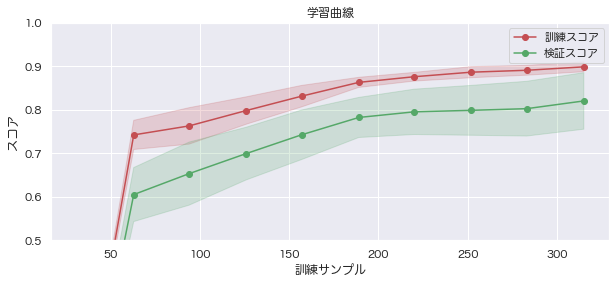

Ridge


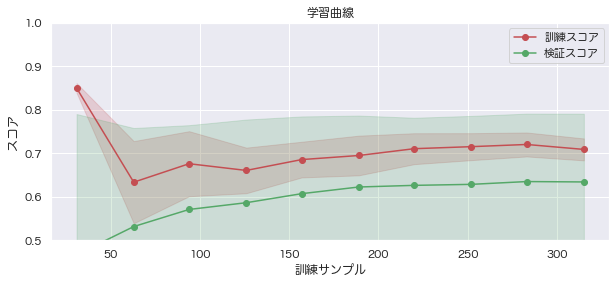

GradientBoostingRegressor


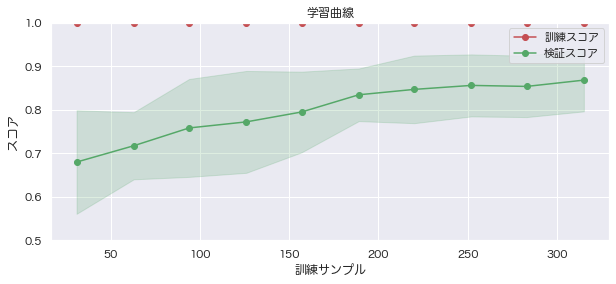

In [84]:
# 学習曲線
for name, model in mdls.items():
    plt_learn_curve(model, boston_df)

Ridge回帰が精度低め。（Ridgeの学習時に）データセットをRidge向けに変換する。  
XGBoostは過学習をおこしているため、過学習対策を行う。  

## 学習の調整

In [85]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# ランダムフォレスト回帰
rfr_model = RFR(
    n_estimators=87,
    n_jobs=8,
    min_samples_split=27,
    max_depth=87
)
# Ridge回帰
ridge_model = make_pipeline(
    StandardScaler(),# 標準化
    Ridge(alpha=0.8, solver='cholesky')
)
# 勾配ブースティング木
gbr_model = GBR(
    max_depth=12,
    subsample=0.5,
    n_estimators=1030,
    learning_rate=0.05,
    validation_fraction=0.1, # 過学習対策
    n_iter_no_change=2, # 過学習対策
    tol=0.0005 # 過学習対策
)

models = [rfr_model, ridge_model, gbr_model]

# 評価
mdls = {}
for model in models:
    mdl = modeling(model, boston_before)
    mdls[model.__class__.__name__] = mdl

RandomForestRegressor
決定係数（R2） =  0.87
平均絶対誤差（MAE） =  2.139
平均二乗平方根誤差（RMSE） =  3.093
RMSE / MAE =  1.446
AIC =  140.794
Pipeline
決定係数（R2） =  0.669
平均絶対誤差（MAE） =  3.186
平均二乗平方根誤差（RMSE） =  4.931
RMSE / MAE =  1.547
AIC =  154.339
GradientBoostingRegressor
決定係数（R2） =  0.906
平均絶対誤差（MAE） =  1.883
平均二乗平方根誤差（RMSE） =  2.62
RMSE / MAE =  1.391
AIC =  138.31


RandomForestRegressor


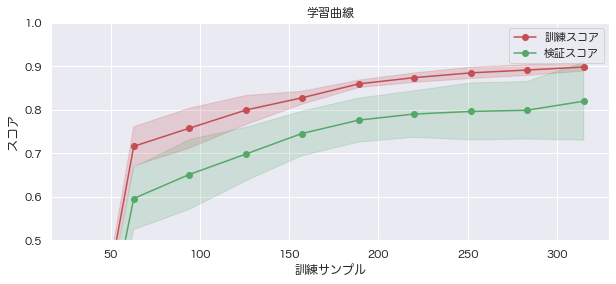

Pipeline


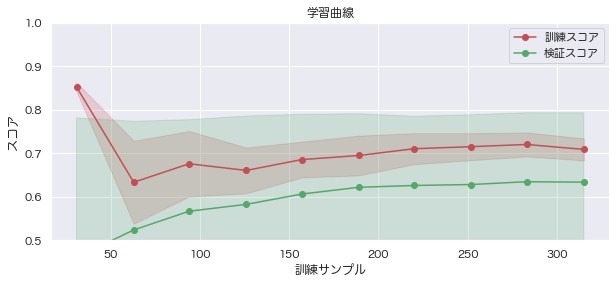

GradientBoostingRegressor


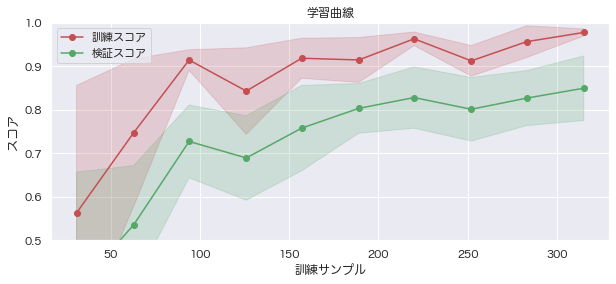

In [86]:
# 学習曲線
for name, model in mdls.items():
    plt_learn_curve(model, boston_df)

訓練スコアと検証スコアの差が全体的に縮まり、過学習が改善されている。    
ただい検証スコア自体にあまり大きな変化はない。この後のアンサンブル学習の評価でどこまで良くなるか確認する。  

# アンサンブル

## スタッキング

In [89]:
# ホールドアウト法
X_train, X_val, y_train, y_val = data_devide(boston_df, test_size=0.3)

X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train2 = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

# モデル
models = [rfr_model, ridge_model, gbr_model]

preds = []
for model in models:
    cv = KFold(n_splits=11, random_state=42, shuffle=True)

    pred_model = np.zeros(len(y_train))
    for trn_index, val_index in cv.split(X_train):
        X_trn, X_val = X_train.iloc[trn_index], X_train.iloc[val_index]
        y_trn, y_val = y_train.iloc[trn_index], y_train.iloc[val_index]

        model.fit(X_trn, y_trn)

        pred_model[val_index] = model.predict(X_val)
        
    preds.append(pred_model)

# 2層目の学習データとして用いる為、学習データの予測値を取得
kf_train = pd.DataFrame({"RFR_予測":preds[0], "RIDGE_予測":preds[1], "DGBR_予測":preds[2]})
# display(kf_train)

# テストデータの予測値を取得
pred_tests = []
for model in models:
    model.fit(X_train, y_train)
    pred_test = model.predict(X_val)
    pred_tests.append(pred_test)

# 2層目の予測データとして用いるため、テストデータの予測値を取得
kf_tests = pd.DataFrame({"RFR_予測":pred_tests[0], "RIDGE_予測":pred_tests[1], "DGBR_予測":pred_tests[2]})
# display(kf_tests)

# 2層目は「ランダムフォレスト回帰」で予測
model2 = rfr_model
model2.fit(kf_train, y_train)
pred_stack = model2.predict(kf_tests);

In [90]:
# １層目の予測値
kf_train.head()

kf_tests.head()

# スタッキングの評価
mae, rmse, aic = evaluation(model2, y_val, pred_stack)

,RFR_予測,RIDGE_予測,DGBR_予測
0,21,22,22
1,22,21,21
2,17,18,19
3,21,17,21
4,35,30,36


,RFR_予測,RIDGE_予測,DGBR_予測
0,17,16,15
1,20,21,20
2,24,28,25
3,27,28,27
4,33,33,32


RandomForestRegressor
決定係数（R2） =  0.974
平均絶対誤差（MAE） =  1.144
平均二乗平方根誤差（RMSE） =  1.425
RMSE / MAE =  1.246
AIC =  62.867


最高スコア。交差検証で当初見積もっていた目標値よりも良い結果が出せている。